**Rolling Window - Used in time-series analysis to analyze values in a fixed dataset. Finds mean or std_dev**
Used to calculate moving averages, or detect patterns
Steps: 
1. A fixed-size window is placed over the first n data points in a sequence
2. A calculation is performed over the data points within that window, eg, mean, std_dev
3. The window then rolls forward by one data point, and the calculation is performed again on the new subset of data
4. This process repeats until the window has moved across the entire dataset.

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
data = yf.download('TSLA', period="1mo")
print(type(data['Close']['TSLA'])) # Choose the ticker inside the OHLCV columns to choose the Series and not DataFrame


/tmp/ipykernel_134255/3463798582.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('TSLA', period="1mo")
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>


/tmp/ipykernel_134255/1189580265.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('TSLA', start="2025-01-01", end="2025-11-13")
[*********************100%***********************]  1 of 1 completed


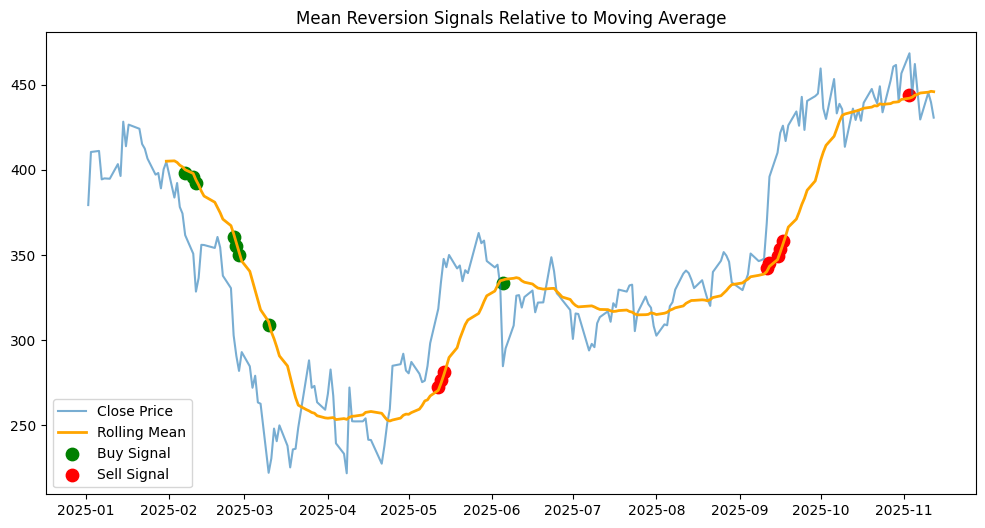

In [ ]:
# yf.download('MSFT', period="1mo")
data = yf.download('TSLA', start="2025-01-01", end="2025-11-13")

# Use rolling window to calculate market results
window = 20 # look-back days
# mean_reversion = (current_price - mean ) / std_deviation
data["mean"] = data['Close']['TSLA'].rolling(window).mean()
data["std"] = data['Close']['TSLA'].rolling(window).std()

data["zscore"] = (data['Close']['TSLA'] - data['mean']) / data["std"]

# If zscore is above 2, the price has deviated too far +vely away from the mean, revert by selling(possibility of bearish)
# If zscore is below 2, the price has deviated too far below the mean, revert by buying(possibility of bullish )

#~ Define signal
data["signal"] = 0
data.loc[data["zscore"] > 2, 'signal'] = -1
data.loc[data["zscore"] < -2, 'signal'] = 1

# Plot the data
# plt.figure(figsize=(12,6))
# plt.plot(data['Close']['TSLA'], label='Close Price', alpha=0.7)
# plt.plot(data['mean'], label='Rolling Mean', color='orange')
# plt.scatter(data.index, data['Close']['TSLA'], c=data['signal'].map({1: 'green', -1: 'red', 0: 'gray'}), label='Signals', alpha=0.8)
# plt.legend()
# plt.title("Mean Reversion Strategy (Z-score method)")
# plt.show()

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price', alpha=0.6)
plt.plot(data['mean'], label='Rolling Mean', linewidth=2, color='orange')

# Buy signals BELOW the mean line
buy_signals = data[data['signal'] == 1]
plt.scatter(buy_signals.index, 
            data.loc[buy_signals.index, 'mean'] - 2,   # small offset below mean
            color='green', label='Buy Signal', s=80)

# Sell signals ABOVE the mean line
sell_signals = data[data['signal'] == -1]
plt.scatter(sell_signals.index, 
            data.loc[sell_signals.index, 'mean'] + 2,   # small offset above mean
            color='red', label='Sell Signal', s=80)

plt.legend()
plt.title("Mean Reversion Signals Relative to Moving Average")
plt.show()


Issues:
- Is the Closing price we are working with the *Adjusted Close* or the *Raw Close*? 
- If it is the Raw Close, we need to find a way to calculate the Adjusted Close, so that we put into consideration dividends and splits.

### Mean-Reversion Report (TSLA) — summary and recommendations

- Strategy setup
    - Universe: TSLA daily OHLCV
    - Rolling window: 20 days
    - Z-score = (Close - rolling_mean) / rolling_std
    - Signals: zscore < -2 => Buy (mean reversion long), zscore > 2 => Sell (short / take profit)

- Dataset overview
    - Total observations: 217 trading days
    - Rolling stats available after warm-up: 198 rows
    - Buy signals: 8
        - Dates (examples): 2025-02-07, 2025-02-10, 2025-02-11, 2025-02-25, 2025-02-26, 2025-02-27, 2025-03-10, 2025-06-05
    - Sell signals: 9
        - Dates (examples): 2025-05-12, 2025-05-13, 2025-05-14, 2025-09-11, 2025-09-12, 2025-09-15, 2025-09-16, 2025-09-17, 2025-11-03

- Key observations from the signals
    - Buy signals occur when price is substantially below the 20-day mean (zscore ≲ -2). Example z-scores: around -2.07 to -2.54.
    - Sell signals occur when price is substantially above the 20-day mean (zscore ≳ 2). Example z-scores: around 2.00 to 3.12.
    - Signals are sparse (17 total across ~11 months), indicating low signal frequency — suitable for event-driven evaluation rather than intraday scalping.

- Risks and caveats
    - No trading costs, slippage, borrowing costs (for shorting) included — these materially affect small-sample strategies.
    - Potential look-ahead bias if evaluation uses future information for exits or performance calculation.
    - Mean-reversion fails in strong trending markets — many buy signals appear in periods of large drawdowns (risk of continuation).

- Suggested next steps (practical)
    1. Backtest performance per signal:
         - Compute entry at close of signal day and exit after fixed horizon (e.g., 5/10/20 days) or when zscore crosses zero.
         - Measure per-trade P&L, win rate, avg return, max drawdown, Sharpe.
    2. Add execution realism:
         - Subtract commissions and slippage, add bid/ask spread.
         - For short signals include borrow fee / margin constraints.
    3. Improve signal logic:
         - Add trend filter (e.g., only buy if 50/200-day SMA indicates non-strong downtrend).
         - Parameter sweep for window length and zscore threshold (grid search or walk-forward).
         - Add stop-loss and profit-target rules to control tail risk.
    4. Risk sizing:
         - Use fixed fractional sizing or volatility parity (size inversely proportional to rolling std).
    5. Validation:
         - Out-of-sample test and cross-validation (avoid overfitting to the shown period).

- Minimal code hints (to implement next steps)
    - Compute counts and quick forward-return test:
    ```python
    # counts
    len(buy_signals), len(sell_signals)

    # example forward return for N days after each buy
    N = 5
    buy_returns = data['Close'].loc[buy_signals.index].shift(-N) / data['Close'].loc[buy_signals.index] - 1
    buy_returns.mean(), buy_returns.describe()
    ```
    - Compute exits based on zscore crossing or fixed horizon similarly.

- Conclusion
    - The 20-day zscore ±2 rule identifies clear mean-reversion events (8 buys, 9 sells). Before deploying, run realistic backtests with transaction costs, tune parameters, and add risk controls (trend filter, stop-loss, position sizing).